In [1]:
import os, sys
import h5py
import numpy as np
from scipy.io import loadmat
import cv2
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import matrix as mat
from sympy import *
from numpy import linalg as la

In [2]:
def getFx(para, frame):   # para中为(13*frame+3)的一套参数，frame传进来是为了确定循环次数
    #先写出参数表达式，ABDCDEF六个点的齐次坐标
    K = Matrix([[1149.67569986785, 0.0, 508.848621645943],
                     [0.0, 1147.59161666764, 508.064917088557],
                     [0.0, 0.0, 1.0]])
    r11, r12, r13, r14, r21, r22, r23, r24, r31, r32, r33 = symbols('r11 r12 r13 r14 r21 r22 r23 r24 r31 r32 r33')
    Rt = Matrix([[r11, r12, r13, r14], [r21, r22, r23, r24], [r31, r32, r33, 1]])
    a, b, c, th, al = symbols('a b c th al')
    ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
    f = Symbol('f')
    XA = Matrix([[-a * c * cos(th) * cos(al)], [c-a * c * sin(th)], [-a * c *  cos(th) * sin(al)], [1]])
    XB = Matrix([[0], [c], [0], [1]])
    XC = Matrix([[a * c * cos(th) * cos(al)], [c+a * c * sin(th)], [a * c * cos(th) * sin(al)], [1]])
    XD = Matrix([[-b * c], [0], [0], [1]])
    XE = Matrix([[0], [0], [0], [1]])
    XF = Matrix([[b * c], [0], [0], [1]])
    ua, va, wa = K[0,:] * (Rt * XA), K[1,:] * (Rt * XA), K[2,:] * (Rt * XA)
    ub, vb, wb = K[0,:] * (Rt * XB), K[1,:] * (Rt * XB), K[2,:] * (Rt * XB)
    uc, vc, wc = K[0,:] * (Rt * XC), K[1,:] * (Rt * XC), K[2,:] * (Rt * XC)
    ud, vd, wd = K[0,:] * (Rt * XD), K[1,:] * (Rt * XD), K[2,:] * (Rt * XD)
    ue, ve, we = K[0,:] * (Rt * XE), K[1,:] * (Rt * XE), K[2,:] * (Rt * XE)
    uf, vf, wf = K[0,:] * (Rt * XF), K[1,:] * (Rt * XF), K[2,:] * (Rt * XF)
    #根据每一帧的循环，提取出Rt的参数，K是公用的，代入参数写出3D坐标，并计算出u/w，v/w
    #写成f的形式，即按照六个点分块，每块里面有M帧
    getfx = mat(np.zeros((6*frame*2,1)))
    for i in range(6):
        for j in range(frame):
            if i == 0 :
                f = Matrix([ua/wa, va/wa])
            elif i == 1 :
                f = Matrix([ub/wb, vb/wb])
            elif i == 2 :
                f = Matrix([uc/wc, vc/wc])
            elif i == 3 :
                f = Matrix([ud/wd, vd/wd])
            elif i == 4 :
                f = Matrix([ue/we, ve/we])
            else:
                f = Matrix([uf/wf, vf/wf])
            f_value = f.subs({r11:para[13*j], r12:para[13*j+1], r13:para[13*j+2], r14:para[13*j+3], 
                        r21:para[13*j+4], r22:para[13*j+5], r23:para[13*j+6], r24:para[13*j+7], 
                        r31:para[13*j+8], r32:para[13*j+9], r33:para[13*j+10], th:para[13*j+11], 
                        al:para[13*j+12], a:para[-3], b:para[-2], c:para[-1]})
            getfx[i*frame*2+j*2] = f_value[0]
            getfx[i*frame*2+j*2+1] = f_value[1]
    #返回getfx值，2*frame*6 by 1
    return getfx

In [3]:
def getJacobian(point, frame, para):
    # 用参数表示K，R矩阵
    focalx, focaly, px, py = symbols('focalx focaly px py')
    r11, r12, r13, r14, r21, r22, r23, r24, r31, r32, r33 = symbols('r11 r12 r13 r14 r21 r22 r23 r24 r31 r32 r33')
    Rt = Matrix([[r11, r12, r13, r14], [r21, r22, r23, r24], [r31, r32, r33, 1]])
    K = Matrix([[focalx, 0, px], [0, focaly, py], [0, 0, 1]])
    # KRt = K * Rt
    # 用参数表示ABCDEF六个点坐标
    a, b, c, th, al = symbols('a b c th al')
    ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
    f = Symbol('f')
    if point == 0 :
        XA = Matrix([[-a * c * cos(th) * cos(al)], [c-a * c * sin(th)], [-a * c *  cos(th) * sin(al)], [1]])
        ua, va, wa = K[0,:] * (Rt * XA), K[1,:] * (Rt * XA), K[2,:] * (Rt * XA)
        f = Matrix([ua/wa, va/wa])
    elif point == 1 :
        XB = Matrix([[0], [c], [0], [1]])
        ub, vb, wb = K[0,:] * (Rt * XB), K[1,:] * (Rt * XB), K[2,:] * (Rt * XB)
        f = Matrix([ub/wb, vb/wb])
    elif point == 2 :
        XC = Matrix([[a * c * cos(th) * cos(al)], [c+a * c * sin(th)], [a * c * cos(th) * sin(al)], [1]])
        uc, vc, wc = K[0,:] * (Rt * XC), K[1,:] * (Rt * XC), K[2,:] * (Rt * XC)
        f = Matrix([uc/wc, vc/wc])
    elif point == 3 :
        XD = Matrix([[-b * c], [0], [0], [1]])
        ud, vd, wd = K[0,:] * (Rt * XD), K[1,:] * (Rt * XD), K[2,:] * (Rt * XD)
        f = Matrix([ud/wd, vd/wd])
    elif point == 4 :
        XE = Matrix([[0], [0], [0], [1]])
        ue, ve, we = K[0,:] * (Rt * XE), K[1,:] * (Rt * XE), K[2,:] * (Rt * XE)
        f = Matrix([ue/we, ve/we])
    elif point == 5:
        XF = Matrix([[b * c], [0], [0], [1]])
        uf, vf, wf = K[0,:] * (Rt * XF), K[1,:] * (Rt * XF), K[2,:] * (Rt * XF)
        f = Matrix([uf/wf, vf/wf])
    args = Matrix([r11, r12, r13, r14, r21, r22, r23, r24, r31, r32, r33, th, al, a, b, c])
    f_X1 = f[0,:].jacobian(args)
    f_X2 = f[1,:].jacobian(args)
    JA = Matrix([f_X1, f_X2])   # 2 by 16 matrix
    JA_value = JA.subs({focalx:1149.676, focaly:1147.592, px:508.849, py:508.065, r11:para[13*frame], r12:para[13*frame+1], 
                                 r13:para[13*frame+2], r14:para[13*frame+3], r21:para[13*frame+4], r22:para[13*frame+5], 
                                 r23:para[13*frame+6], r24:para[13*frame+7], r31:para[13*frame+8], r32:para[13*frame+9], 
                                 r33:para[13*frame+10], th:para[13*frame+11], al:para[13*frame+12], a:para[-3], b:para[-2], c:para[-1]})
    #JA_value = JA_value.subs({f:1149.68})
    return JA_value

In [4]:
def getJ(para, frame):
    getj = mat(np.zeros((6*frame*2, 13*frame+3)))
    for m in range(6):
        for n in range(frame):
            JA_value = getJacobian(m, n, para)
            #print(JA_value)
            getj[2*(m*frame+n):2*(m*frame+n+1), 13*n:13*n+13] = JA_value[:, 0:13]
            getj[2*(m*frame+n):2*(m*frame+n+1), -3:] = JA_value[:, -3:]
    return getj

In [5]:
def getE(getfx, frame):
    E = mat(np.zeros((6*frame*2,1)))
    for i in range(6):
        for j in range(frame):
            if i==0 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - x2d[i,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - x2d[i, 1]
            elif i==1 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - x2d[i,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - x2d[i, 1]
            elif i==2 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - x2d[i,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - x2d[i, 1]
            elif i==3 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - x2d[i,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - x2d[i, 1]
            elif i==4 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - x2d[i,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - x2d[i, 1]
            elif i==5 :
                E[(i*frame+j)*2] = getfx[i*frame*2+j*2] - x2d[i,0]
                E[(i*frame+j)*2+1] = getfx[i*frame*2+j*2+1] - x2d[i, 1]
    return E

In [47]:
def LM_opti(frame, x_para, u=1, v=2, step_max=500):
    J = mat(np.zeros((6*frame*2, 13*frame+3)))
    E = mat(np.zeros((6*frame*2,1)))   # E = f(X) - b ;
    E_temp = mat(np.zeros((6*frame*2,1)))   # E_temp compare with E in L-M
    x_k = mat(x_para.copy())   #parameter initialization
    step = 0   # iteration steps
    mse_last = 0   # mse value after iteration each time
    step_max = 500   # maximum number of iteration
    u = 1
    v = 2   # u, v initial value
    # L-M Algorithm obtain optimal parameters
    while(step < step_max):
        step += 1
        mse, mse_temp = 0, 0

        # generate Jacobian Matrix and calculate E
        getfx = mat(np.zeros((6*frame*2,1)))
        getfx = getFx(x_k, frame)
        E = getE(getfx, frame)

        for i in range(6*frame*2):
            mse += E[i]**2
        mse /= 6*frame*2

        # get new J
        J = mat(np.zeros((6*frame*2, 13*frame+3)))
        J = getJ(x_k, frame)

        # delta X = ...
        #print(J.T * J)
        dx = mat(np.zeros((13*frame+3,1)))
        LM = u * mat(np.eye(13*frame+3))
        dx = -(J.T * J + LM).I * J.T * E
        x_k_temp = x_k.copy()
        x_k_temp += dx
        
        #R的更新不能简单赋值
        #get R meet R.T*R=I
        #U * D * V.T = R --> R+ = U * V.T
        R_old = mat([[x_k_temp[0,0], x_k_temp[1,0], x_k_temp[2,0]], 
                     [x_k_temp[4,0], x_k_temp[5,0], x_k_temp[6,0]], 
                     [x_k_temp[8,0], x_k_temp[9,0], x_k_temp[10,0]]])
        U, sigma, VT = la.svd(R_old)
        R_new = U * VT
        x_k_temp[0,0], x_k_temp[1,0], x_k_temp[2,0] = R_new[0,0], R_new[0,1], R_new[0,2]
        x_k_temp[4,0], x_k_temp[5,0], x_k_temp[6,0] = R_new[1,0], R_new[1,1], R_new[1,2]
        x_k_temp[8,0], x_k_temp[9,0], x_k_temp[10,0] = R_new[2,0], R_new[2,1], R_new[2,2]
        ###########

        # calculate E_temp with x_k_temp
        # copy from E with x_k
        getfx_temp = mat(np.zeros((6*frame*2,1)))
        getfx_temp = getFx(x_k_temp, frame)
        E_temp = getE(getfx_temp, frame)

        for i in range(6*frame*2):
            mse_temp += E_temp[i]**2
        mse_temp /= 6*frame*2

        # segma value to choose optimization model
        segma = (mse - mse_temp)/((dx.T * (u * dx - J.T * E))[0,0])

        # calculate new u
        if segma > 0:
            s = 1.0/3.0
            v = 2
            x_k = x_k_temp
            mse = mse_temp
            u = u * max(s, 1-pow(2*segma,3))
            u = u[0,0]
        else:
            u = u * v
            v = v * 2
            x_k = x_k_temp
            
        print("step = %d, abs(mse-mse_last) = %.8f" %(step, abs(mse-mse_last)))
        if abs(mse-mse_last)<0.000001:
            break    
        mse_last = mse

    print("step = ", step)
    print("mse = ", mse_last)
    #print("parameter = ", x_k)
    
    return x_k

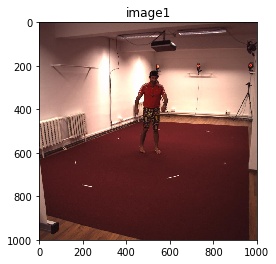

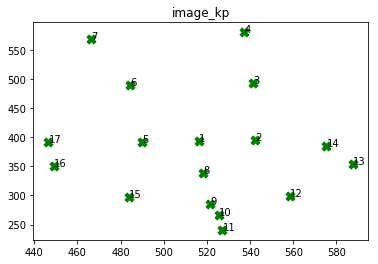

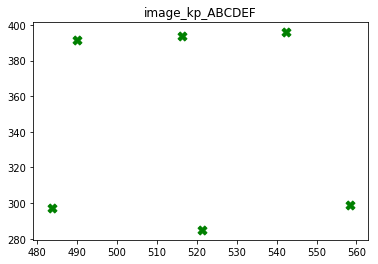

[[483.83330182 297.02895882]
 [521.42362196 285.01172463]
 [558.27002512 298.71850852]
 [490.11721691 391.47081586]
 [516.29540914 393.64693794]
 [542.46158091 395.86354434]]


In [7]:
# 数据读取
frame = 1
m = loadmat("valid.mat")
# camera intrinsic matrix
K = m["annot"][0][0][4]
K_cam = K[0][0].tolist()
# key point 3D groundtruth
gt = m["annot"][0][0][3]
img1_gt = gt[135]   # array 3 by 17
kp = np.zeros((17,2))
for i in range(17):
    u = K_cam[0] * mat([img1_gt[0][i], img1_gt[1][i], img1_gt[2][i]]).T
    v = K_cam[1] * mat([img1_gt[0][i], img1_gt[1][i], img1_gt[2][i]]).T
    w = K_cam[2] * mat([img1_gt[0][i], img1_gt[1][i], img1_gt[2][i]]).T
    kp[i][0] = u/w
    kp[i][1] = v/w
# load  and show image
img = cv2.imread("S9_Posing_1.55011271_000676.jpg")
plt.figure("Image") # 图像窗口名称
plt.imshow(img[:,:,[2,1,0]])
plt.axis('on') # 关掉坐标轴为 off
plt.title('image1') # 图像题目
plt.show()
# visualize key points
txt = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']
img_kp = plt.scatter(kp[:,0], kp[:,1], s = 80, c = 'g', marker = 'X')
for i in range(17):
    plt.annotate(txt[i], xy = (kp[i,0], kp[i,1]), xytext = (kp[i,0]+0.1, kp[i,1]+0.1)) # 这里xy是需要标记的坐标，xytext是对应的标签坐标
plt.axis('on') # 关掉坐标轴为 off
plt.title('image_kp') # 图像题目
# visualize ABCDEF
plt.figure()
img_kp = plt.scatter(kp[0,0], kp[0,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(kp[1,0], kp[1,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(kp[4,0], kp[4,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(kp[8,0], kp[8,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(kp[11,0], kp[11,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(kp[14,0], kp[14,1], s = 80, c = 'g', marker = 'X')
plt.axis('on') # 关掉坐标轴为 off
plt.title('image_kp_ABCDEF') # 图像题目
plt.show()
# save 2D coordinate to list
x2d = np.zeros((6 * frame,2))
x2d[0,0] = kp[0,0]
for i in range(6):
    for j in range(frame):
        if i==0 :
            x2d[i*frame+j, 0] = kp[14, 0]
            x2d[i*frame+j, 1] = kp[14, 1]
        elif i==1 :
            x2d[i*frame+j, 0] = kp[8, 0]
            x2d[i*frame+j, 1] = kp[8, 1]
        elif i==2 :
            x2d[i*frame+j, 0] = kp[11, 0]
            x2d[i*frame+j, 1] = kp[11, 1]
        elif i==3 :
            x2d[i*frame+j, 0] = kp[4, 0]
            x2d[i*frame+j, 1] = kp[4, 1]
        elif i==4 :
            x2d[i*frame+j, 0] = kp[0, 0]
            x2d[i*frame+j, 1] = kp[0, 1]
        elif i==5 :
            x2d[i*frame+j, 0] = kp[1, 0]
            x2d[i*frame+j, 1] = kp[1, 1]
print(x2d)

In [8]:
# parameter initialization for all frame (K_cam, x2d(6*frame by 2))
# x_para(13*frame+3)
x_para = np.zeros((13*frame+3,1))
for i in range(frame):
    x_para[13*i] = -1   # r11
    x_para[13*i+5] = 1   # r22
    x_para[13*i+10] = -1   # r33
    x_para[13*i+3] = 0.0047
    x_para[13*i+7] = -0.0997
    x_para[13*i+11] = 0   # th
    x_para[13*i+12] = 0   #al
x_para[-3] = 0.35   # a
x_para[-2] = 0.25   # b
distance = -0.095#0.096   # c
x_para[-1] = distance
print(mat(x_para.copy()))
getfx_ini = getFx(x_para, frame)
print(getfx_ini)

[[-1.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.0047]
 [ 0.    ]
 [ 1.    ]
 [ 0.    ]
 [-0.0997]
 [ 0.    ]
 [ 0.    ]
 [-1.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.35  ]
 [ 0.25  ]
 [-0.095 ]]
[[476.02538041]
 [284.62882932]
 [514.25209744]
 [284.62882932]
 [552.47881446]
 [284.62882932]
 [486.94729956]
 [393.65003291]
 [514.25209744]
 [393.65003291]
 [541.55689531]
 [393.65003291]]


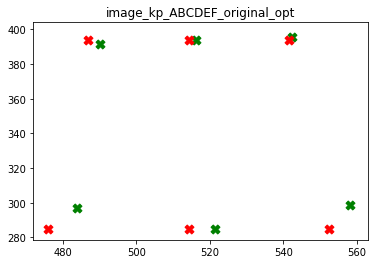

In [9]:
plt.figure()
img_kp = plt.scatter(kp[14,0], kp[14,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[0,0], getfx_ini[1,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[8,0], kp[8,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[2,0], getfx_ini[3,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[11,0], kp[11,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[4,0], getfx_ini[5,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[4,0], kp[4,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[6,0], getfx_ini[7,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0,0], kp[0,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[8,0], getfx_ini[9,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[1,0], kp[1,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_ini[10,0], getfx_ini[11,0], s = 80, c = 'r', marker = 'X')
plt.axis('on') # 关掉坐标轴为 off
plt.title('image_kp_ABCDEF_original_opt') # 图像题目
plt.show()

In [48]:
x_k = LM_opti(frame, x_para)
R_old = mat([[x_k[0,0], x_k[1,0], x_k[2,0]], 
             [x_k[4,0], x_k[5,0], x_k[6,0]], 
             [x_k[8,0], x_k[9,0], x_k[10,0]]])
U, sigma, VT = la.svd(R_old)
R_new = U * VT
x_k[0,0], x_k[1,0], x_k[2,0] = R_new[0,0], R_new[0,1], R_new[0,2]
x_k[4,0], x_k[5,0], x_k[6,0] = R_new[1,0], R_new[1,1], R_new[1,2]
x_k[8,0], x_k[9,0], x_k[10,0] = R_new[2,0], R_new[2,1], R_new[2,2]

step = 1, abs(mse-mse_last) = 9.83445441
step = 2, abs(mse-mse_last) = 0.07658973
step = 3, abs(mse-mse_last) = 0.03711521
step = 4, abs(mse-mse_last) = 0.00000000
step =  4
mse =  [[9.72074947]]


[[-0.9961843 ]
 [-0.06427425]
 [ 0.05903942]
 [ 0.00649174]
 [-0.06445466]
 [ 0.99791997]
 [-0.00115447]
 [-0.09968937]
 [-0.05884241]
 [-0.00495543]
 [-0.99825498]
 [ 0.09610256]
 [ 0.16333518]
 [ 0.38184965]
 [ 0.26152886]
 [-0.08737298]]
[[485.20707932]
 [293.35576592]
 [522.76237439]
 [293.69511012]
 [559.77099998]
 [294.02951469]
 [490.11633534]
 [391.81572939]
 [516.31201181]
 [393.66223735]
 [542.4373384 ]
 [395.50378642]]


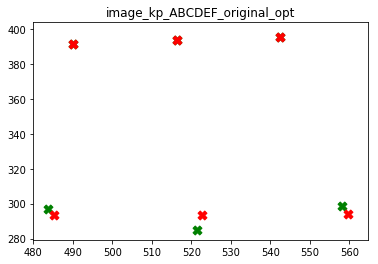

In [11]:
# visualize keypoint after BA
# compare with image_kp_ABCDEF
print(x_k)
getfx_final = getFx(x_k, frame)
print(getfx_final)
plt.figure()
img_kp = plt.scatter(kp[14,0], kp[14,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_final[0,0], getfx_final[1,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[8,0], kp[8,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_final[2,0], getfx_final[3,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[11,0], kp[11,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_final[4,0], getfx_final[5,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[4,0], kp[4,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_final[6,0], getfx_final[7,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[0,0], kp[0,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_final[8,0], getfx_final[9,0], s = 80, c = 'r', marker = 'X')
img_kp = plt.scatter(kp[1,0], kp[1,1], s = 80, c = 'g', marker = 'X')
img_kp = plt.scatter(getfx_final[10,0], getfx_final[11,0], s = 80, c = 'r', marker = 'X')
plt.axis('on') # 关掉坐标轴为 off
plt.title('image_kp_ABCDEF_original_opt') # 图像题目
plt.show()

In [12]:
def getValue(X3D, para):
    j = 0
    X3D_value = X3D.subs({r11:para[13*j], r12:para[13*j+1], r13:para[13*j+2], r14:para[13*j+3], 
            r21:para[13*j+4], r22:para[13*j+5], r23:para[13*j+6], r24:para[13*j+7], 
            r31:para[13*j+8], r32:para[13*j+9], r33:para[13*j+10], th:para[13*j+11], 
            al:para[13*j+12], a:para[-3], b:para[-2], c:para[-1]})
    return X3D_value

In [28]:
# visualize 3D points and groundtruth
# XA,XB,XC,XD,XE,XF with GT[14,8,11,4,0,1]
para = x_k.copy()
K = Matrix([[1149.67569986785, 0.0, 508.848621645943],
                 [0.0, 1147.59161666764, 508.064917088557],
                 [0.0, 0.0, 1.0]])
r11, r12, r13, r14, r21, r22, r23, r24, r31, r32, r33 = symbols('r11 r12 r13 r14 r21 r22 r23 r24 r31 r32 r33')
Rt = Matrix([[r11, r12, r13, r14], [r21, r22, r23, r24], [r31, r32, r33, 1]])
a, b, c, th, al = symbols('a b c th al')
ua, va, wa, ub, vb, wb, uc, vc, wc, ud, vd, wd, ue, ve, we, uf, vf, wf = symbols('ua va wa ub vb wb uc vc wc ud vd wd ue ve we uf vf wf')
XA = Matrix([[-a * c * cos(th) * cos(al)], [c-a * c * sin(th)], [-a * c *  cos(th) * sin(al)], [1]])
XB = Matrix([[0], [c], [0], [1]])
XC = Matrix([[a * c * cos(th) * cos(al)], [c+a * c * sin(th)], [a * c * cos(th) * sin(al)], [1]])
XD = Matrix([[-b * c], [0], [0], [1]])
XE = Matrix([[0], [0], [0], [1]])
XF = Matrix([[b * c], [0], [0], [1]])
A3D = Rt * XA
B3D = Rt * XB
C3D = Rt * XC
D3D = Rt * XD
E3D = Rt * XE
F3D = Rt * XF
j = 0
#A3D_value = A3D.subs({r11:para[13*j], r12:para[13*j+1], r13:para[13*j+2], r14:para[13*j+3], 
#            r21:para[13*j+4], r22:para[13*j+5], r23:para[13*j+6], r24:para[13*j+7], 
#            r31:para[13*j+8], r32:para[13*j+9], r33:para[13*j+10], th:para[13*j+11], 
#            al:para[13*j+12], a:para[-3], b:para[-2], c:para[-1]})
Y = mat([img1_gt[0][0], img1_gt[1][0], img1_gt[2][0]]).T
s = Y[2,0]
print(s)
A3D_value = getValue(A3D, para) * s
B3D_value = getValue(B3D, para) * s
C3D_value = getValue(C3D, para) * s
D3D_value = getValue(D3D, para) * s
E3D_value = getValue(E3D, para) * s
F3D_value = getValue(F3D, para) * s
'''
E3D_value = (getValue(E3D, para) - getValue(E3D, para))*s
A3D_value = (getValue(A3D, para) - getValue(E3D, para))*s
B3D_value = (getValue(B3D, para) - getValue(E3D, para))*s
C3D_value = (getValue(C3D, para) - getValue(E3D, para))*s
D3D_value = (getValue(D3D, para) - getValue(E3D, para))*s
F3D_value = (getValue(F3D, para) - getValue(E3D, para))*s
'''
print(A3D_value)
print(B3D_value)
print(C3D_value)
print(D3D_value)
print(E3D_value)
print(F3D_value)

5431.021804471869
Matrix([[-110.910895781011], [-1009.10636889366], [5393.53820265049]])
Matrix([[65.7564671098120], [-1014.95267461836], [5433.37327752853]])
Matrix([[242.423830000635], [-1020.79898034306], [5473.20835240656]])
Matrix([[-88.3715849144842], [-549.414059608507], [5423.71935115701]])
Matrix([[35.2567551853507], [-541.415115889804], [5431.02180447187]])
Matrix([[158.885095285186], [-533.416172171102], [5438.32425778673]])


In [29]:
Y = mat([img1_gt[0][0], img1_gt[1][0], img1_gt[2][0]]).T
print(Y[2,0])
X1 = mat([img1_gt[0][14], img1_gt[1][14], img1_gt[2][14]]).T
X2 = mat([img1_gt[0][8], img1_gt[1][8], img1_gt[2][8]]).T
X3 = mat([img1_gt[0][11], img1_gt[1][11], img1_gt[2][11]]).T
X4 = mat([img1_gt[0][4], img1_gt[1][4], img1_gt[2][4]]).T
X5 = mat([img1_gt[0][0], img1_gt[1][0], img1_gt[2][0]]).T
X6 = mat([img1_gt[0][1], img1_gt[1][1], img1_gt[2][1]]).T
print(X1, X2, X3, X4, X5, X6)
'''
#s = 5340.55881868
X1 = (mat([img1_gt[0][14], img1_gt[1][14], img1_gt[2][14]]).T-Y)
print(X1)
X2 = (mat([img1_gt[0][8], img1_gt[1][8], img1_gt[2][8]]).T-Y)
print(X2)
X3 = (mat([img1_gt[0][11], img1_gt[1][11], img1_gt[2][11]]).T-Y)
print(X3)
X4 = (mat([img1_gt[0][4], img1_gt[1][4], img1_gt[2][4]]).T-Y)
print(X4)
X5 = (mat([img1_gt[0][0], img1_gt[1][0], img1_gt[2][0]]).T-Y)
print(X5)
X6 = (mat([img1_gt[0][1], img1_gt[1][1], img1_gt[2][1]]).T-Y)
print(X6)
'''

5431.021804471869
[[-116.13794622]
 [-981.55022671]
 [5337.56816021]] [[   58.10612376]
 [-1032.54818762]
 [ 5312.38145874]] [[ 229.57596842]
 [-974.23751811]
 [5340.55881868]] [[ -88.47243168]
 [-551.69897883]
 [5430.16427386]] [[  35.17832488]
 [-541.48752095]
 [5431.02180447]] [[ 158.81323565]
 [-531.08752521]
 [5431.94416176]]


'\n#s = 5340.55881868\nX1 = (mat([img1_gt[0][14], img1_gt[1][14], img1_gt[2][14]]).T-Y)\nprint(X1)\nX2 = (mat([img1_gt[0][8], img1_gt[1][8], img1_gt[2][8]]).T-Y)\nprint(X2)\nX3 = (mat([img1_gt[0][11], img1_gt[1][11], img1_gt[2][11]]).T-Y)\nprint(X3)\nX4 = (mat([img1_gt[0][4], img1_gt[1][4], img1_gt[2][4]]).T-Y)\nprint(X4)\nX5 = (mat([img1_gt[0][0], img1_gt[1][0], img1_gt[2][0]]).T-Y)\nprint(X5)\nX6 = (mat([img1_gt[0][1], img1_gt[1][1], img1_gt[2][1]]).T-Y)\nprint(X6)\n'

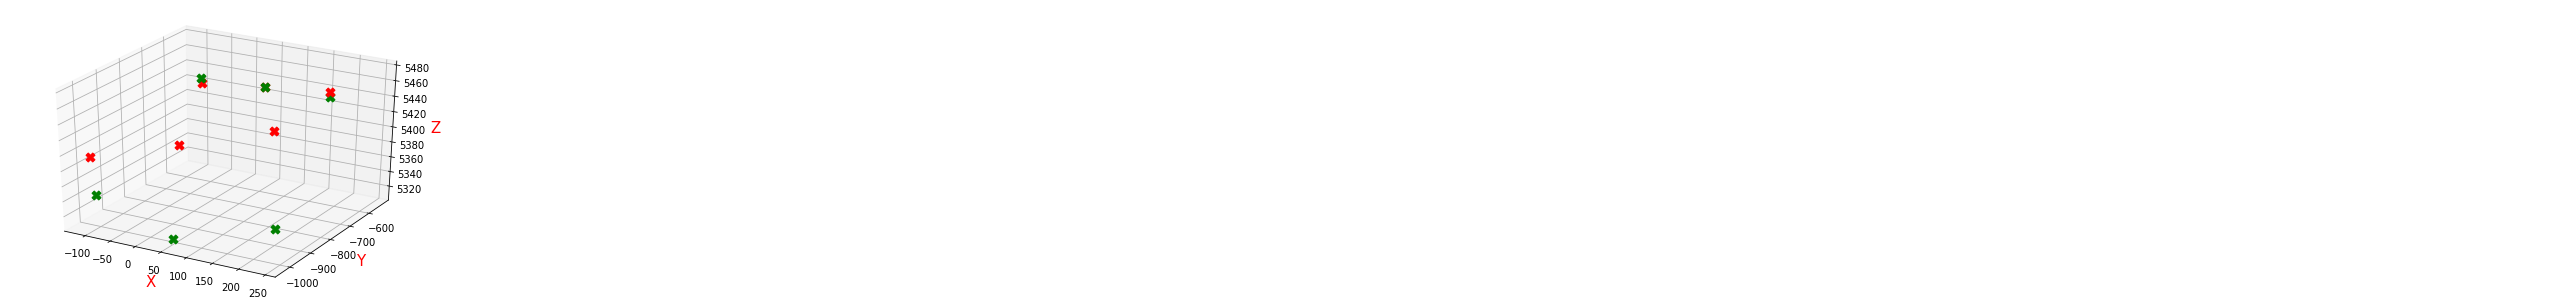

In [30]:
# 绘制散点图
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X1[0], X1[1], X1[2], s = 80, c = 'g', marker = 'X')
ax.scatter(X2[0], X2[1], X2[2], s = 80, c = 'g', marker = 'X')
ax.scatter(X3[0], X3[1], X3[2], s = 80, c = 'g', marker = 'X')
ax.scatter(X4[0], X4[1], X4[2], s = 80, c = 'g', marker = 'X')
ax.scatter(X5[0], X5[1], X5[2], s = 80, c = 'g', marker = 'X')
ax.scatter(X6[0], X6[1], X6[2], s = 80, c = 'g', marker = 'X')
ax.scatter(A3D_value[0], A3D_value[1], A3D_value[2], s = 80, c = 'r', marker = 'X')
ax.scatter(B3D_value[0], B3D_value[1], B3D_value[2], s = 80, c = 'r', marker = 'X')
ax.scatter(C3D_value[0], C3D_value[1], C3D_value[2], s = 80, c = 'r', marker = 'X')
ax.scatter(D3D_value[0], D3D_value[1], D3D_value[2], s = 80, c = 'r', marker = 'X')
ax.scatter(E3D_value[0], E3D_value[1], E3D_value[2], s = 80, c = 'r', marker = 'X')
ax.scatter(F3D_value[0], F3D_value[1], F3D_value[2], s = 80, c = 'r', marker = 'X')

ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
plt.show()

In [46]:
# 计算3D error
d1 = A3D_value-X1
e1 = sum(map(lambda x:x**2, d1))
d2 = B3D_value-X2
e2 = sum(map(lambda x:x**2, d2))
d3 = C3D_value-X3
e3 = sum(map(lambda x:x**2, d3))
d4 = D3D_value-X4
e4 = sum(map(lambda x:x**2, d4))
d5 = E3D_value-X5
e5 = sum(map(lambda x:x**2, d5))
d6 = F3D_value-X6
e6 = sum(map(lambda x:x**2, d6))
error = (e1**(0.5)+e2**(0.5)+e3**(0.5)+e4**(0.5)+e5**(0.5)+e6**(0.5))/6
print(error)
print(d1,d2,d3,d4,d5,d6)

56.6692591685530
Matrix([[5.22705044046768], [-27.5561421819614], [55.9700424388993]]) Matrix([[7.65034334947030], [17.5955130062730], [120.991818785437]]) Matrix([[12.8478615774326], [-46.5614622292373], [132.649533729206]]) Matrix([[0.100846761598120], [2.28491922030128], [-6.44492270138107]]) Matrix([[0.0784303060919385], [0.0724050617569674], [0]]) Matrix([[0.0718596378686982], [-2.32864695846297], [6.38009602800958]])
